<a href="https://colab.research.google.com/github/halfendt/hello-world/blob/master/Flower_ConvNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import files
uploaded = files.upload()

Saving flower_imgs.npy to flower_imgs (1).npy


In [6]:
# Import necessary modules
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.


In [7]:
# Load image data
labels = np.load('flower_labels.npy')
print('Image label shape', labels.shape)

# Load label data
images = np.load('flower_imgs.npy')
print('Image data shape', images.shape)

Image label shape (4323,)
Image data shape (4323, 32, 32, 3)


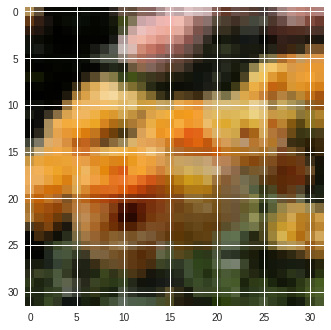

In [8]:
# Display an image from data
plt.imshow(images[2480])
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


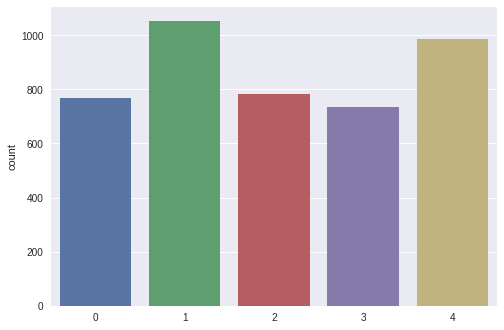

In [9]:
# Plot count of each class
sns.countplot(labels)
plt.show()

In [10]:
# Split data into training and test sets: test size is 30%, split is stratified by image label
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)

# Display sizes of training and test sets
print('Training data shape :', 'X =', X_train.shape, ' y =', y_train.shape)
print('Testing data shape : ', 'X =', X_test.shape, ' y =', y_test.shape)
print('')

# Display number of output classes
classes = np.unique(y_train)
nClasses = len(classes)
print('Total number of outputs :', nClasses)
print('Output classes :', classes)

Training data shape : X = (3026, 32, 32, 3)  y = (3026,)
Testing data shape :  X = (1297, 32, 32, 3)  y = (1297,)

Total number of outputs : 5
Output classes : [0 1 2 3 4]


In [11]:
# Normalize data
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.
X_test = X_test / 255.

# Change the labels from categorical to one-hot encoding
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Display the change for category label using one-hot encoding
print('Original label:', y_train[0])
print('After conversion to one-hot:', y_train_one_hot[0])
print('')

# Display sizes of training and testing data
print('X_train =', X_train.shape, 'y_train =', y_train_one_hot.shape) 
print('X_test =', X_test.shape, 'y_test =', y_test_one_hot.shape)

Original label: 1
After conversion to one-hot: [0. 1. 0. 0. 0.]

X_train = (3026, 32, 32, 3) y_train = (3026, 5)
X_test = (1297, 32, 32, 3) y_test = (1297, 5)


In [0]:
# With data augmentation to prevent overfitting
datagen = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset
                             samplewise_center=False,  # set each sample mean to 0
                             featurewise_std_normalization=False,  # divide inputs by std of the dataset
                             samplewise_std_normalization=False,  # divide each input by its std
                             zca_whitening=False,  # apply ZCA whitening
                             rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
                             zoom_range = 0.1, # Randomly zoom image 
                             width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
                             height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
                             horizontal_flip=True,  # randomly flip images
                             vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0000001)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 8, 128)         0         
__________

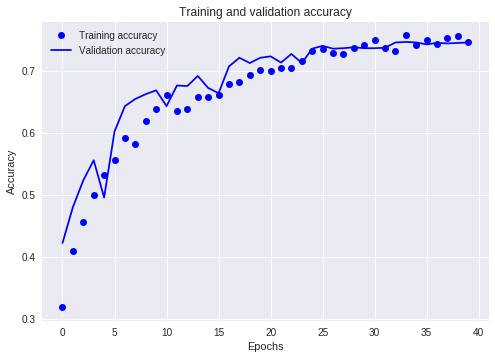

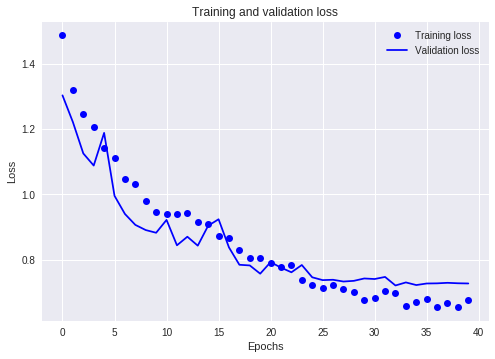

In [25]:
size1 = 64
size2 = 64
size3 = 128
size4 = 128
k12 = 3
k34 = 3
d1 = 256
drop1 = 0.125
drop2 = 0.75

#param_grid = dict(size1=[16,32,64], (size2=[16,32,64])
#grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
#grid_result = grid.fit(X, Y)

# Build CNN architecture
model = Sequential()
model.add(Conv2D(size1, kernel_size=(k12, k12), activation='relu', input_shape=X_train[0].shape, padding='same'))
model.add(Conv2D(size2, kernel_size=(k12, k12), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(drop1))
model.add(Conv2D(size3, kernel_size=(k34, k34), activation='relu', padding='same'))
model.add(Conv2D(size4, kernel_size=(k34, k34), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(drop1))
model.add(Flatten())
model.add(Dense(d1, activation='relu'))
model.add(Dropout(drop2))
model.add(Dense(nClasses, activation='softmax'))

# Print model summary
print(model.summary())

# Compile model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fit model
batch_size = 64
train = model.fit_generator(datagen.flow(X_train, y_train_one_hot, batch_size = batch_size),
                            epochs = 40, validation_data = (X_test, y_test_one_hot),
                            verbose = 1, steps_per_epoch = X_train.shape[0] // batch_size,
                            callbacks = [learning_rate_reduction])

# Print loss and accuracy for test data
test_eval = model.evaluate(X_test, y_test_one_hot, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

# Plot loss and accuracy for training and test data 
accuracy = train.history['acc']
val_accuracy = train.history['val_acc']
loss = train.history['loss']
val_loss = train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [14]:
# Predict classes for test data
predicted_classes = model.predict(X_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes.shape, y_test.shape

((1297,), (1297,))

Found 917 correct labels


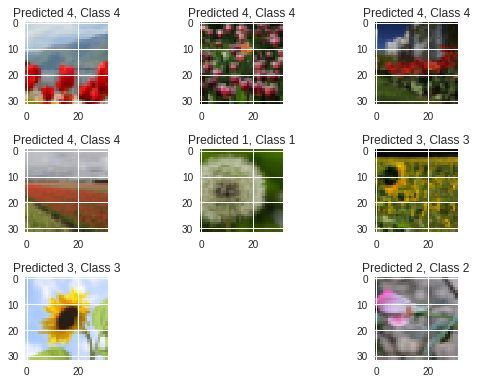

In [15]:
# Plot several correctly labeled images
correct = np.where(predicted_classes==y_test)[0]
print('Found %d correct labels' % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(32,32,3), interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    plt.tight_layout()

Found 380 incorrect labels


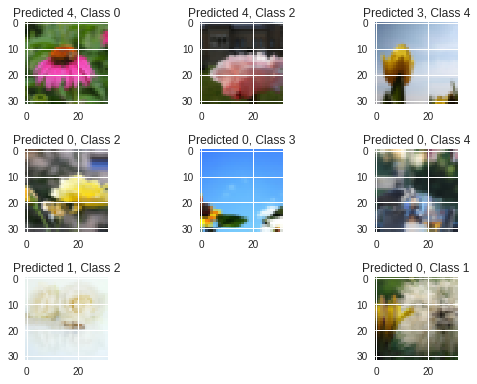

In [16]:
# Plot several incorrectly labeled images
incorrect = np.where(predicted_classes!=y_test)[0]
print('Found %d incorrect labels' % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(32,32,3), interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
    plt.tight_layout()

In [17]:
# Print classification report
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(y_test, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.50      0.86      0.63       231
     Class 1       0.83      0.67      0.74       316
     Class 2       0.73      0.62      0.67       235
     Class 3       0.80      0.83      0.81       220
     Class 4       0.82      0.61      0.70       295

   micro avg       0.71      0.71      0.71      1297
   macro avg       0.74      0.72      0.71      1297
weighted avg       0.75      0.71      0.71      1297



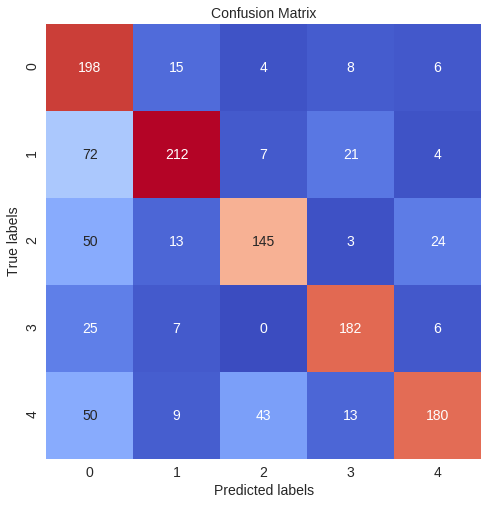

In [18]:
# Display confusion matrix, with rows same as classification report 
cm = confusion_matrix(y_test, predicted_classes)
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cm, annot=True, ax = ax, cmap='coolwarm', annot_kws={"size": 14}, 
            cbar=False, square=True, fmt='.3g')
ax.set_xlabel('Predicted labels', fontsize = 14)
ax.set_ylabel('True labels', fontsize = 14)
ax.set_title('Confusion Matrix', fontsize = 14) 
ax.xaxis.set_ticklabels(np.sort(np.unique(y_test)))
ax.yaxis.set_ticklabels(-np.sort(-np.unique(y_test)))
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.show()